---

# Chroma feature extraction

>This notebook contains code computing chroma features

---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from spleeter.separator import Separator
from openunmix import predict

In [2]:
collection_path = 'collection'
query_path = 'queries'
raw_path = 'chroma/raw'
spleeter_path = 'chroma/spleeter'
openunmix_path = 'chroma/openunmix'
query_chroma_path = 'chroma/queries'

### Raw audio chroma features

- Compute and save raw audio `chroma` for the collection

> Skipping songs longer than 3:30 minutes due to resource limitations

In [3]:
# Create directory to save chroma features
os.makedirs(raw_path, exist_ok=True)

for file_name in os.listdir(collection_path):
    if file_name.endswith(".mp3"):
        file_path = os.path.join(collection_path, file_name)

        # Load audio
        y, sr = librosa.load(file_path)

        # Skip if too lengthy
        if librosa.get_duration(y=y, sr=sr) > 210:
            continue

        # Compute chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=2048, hop_length=512)
        y = None
        
        # Save chroma features
        base_name = os.path.splitext(file_name)[0]
        save_path = f"{base_name}.npy"
        np.save(os.path.join(raw_path, save_path), chroma, allow_pickle=False)

In [21]:
example_chroma = np.load(os.path.join(raw_path, '1224.npy'))

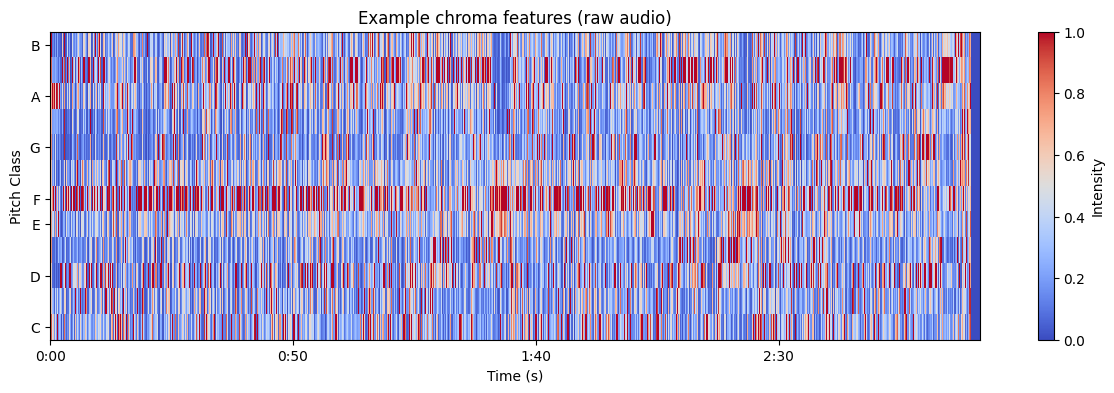

In [22]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(example_chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar(label="Intensity")
plt.title("Example chroma features (raw audio)")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

### Source seperated chroma features (spleeter)

- Extract vocals from raw audio using `spleeter`
- Compute and save `chroma` for the collection

In [7]:
separator = Separator('spleeter:2stems')

In [7]:
# Create directory to save chroma features
os.makedirs(spleeter_path, exist_ok=True)

for file_name in os.listdir(collection_path):
    if file_name.endswith(".mp3"):
        file_path = os.path.join(collection_path, file_name)

        # Load audio
        y, sr = librosa.load(file_path)

        # Skip if too lengthy
        if librosa.get_duration(y=y, sr=sr) > 210:
            continue
        y = None
        
        # Save source seperated vocals using spleeter
        separator.separate_to_file(file_path, 'spleeter')

        # Load vocals
        root = 'spleeter'
        sub = os.path.splitext(file_name)[0]
        base_name = 'vocals.wav'
        file_path = os.path.join(root, sub, base_name)
        y, sr = librosa.load(file_path)

        # Compute chroma features for source seperated vocals
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=2048, hop_length=512)
        y = None
        
        # Save chroma features
        base_name = os.path.splitext(file_name)[0]
        save_path = f"{base_name}.npy"
        np.save(os.path.join(spleeter_path, save_path), chroma, allow_pickle=False)

INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models/2stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
INFO:tensorflow:Calling model_fn.
INFO:tensorflo

In [23]:
example_chroma = np.load(os.path.join(spleeter_path, '1224.npy'))

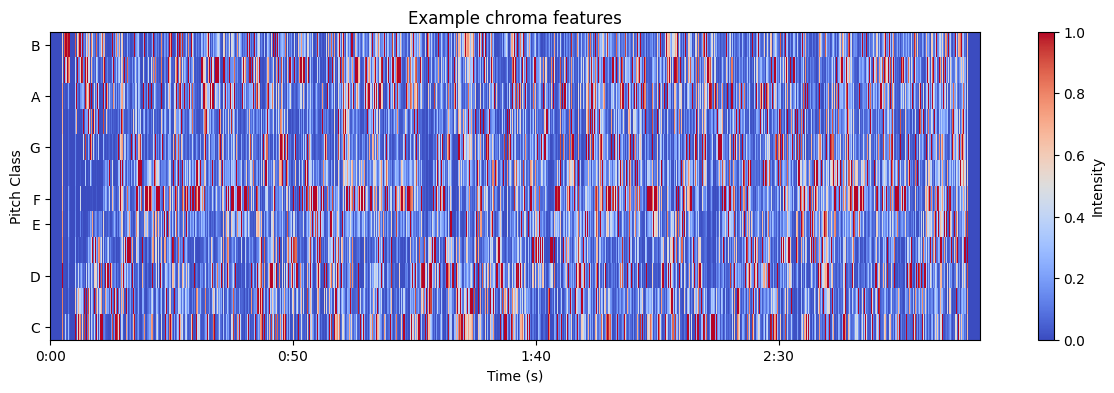

In [24]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(example_chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar(label="Intensity")
plt.title("Example chroma features")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

### Source seperated chroma features (open unmix)

- Extract vocals from raw audio using `openunmix`
- Compute and save `chroma` for the collection

In [3]:
# Create directory to save chroma features
os.makedirs(openunmix_path, exist_ok=True)

for file_name in os.listdir(collection_path):
    if file_name.endswith(".mp3"):
        file_path = os.path.join(collection_path, file_name)

        # Load audio
        y, sr = librosa.load(file_path)

        # Skip if too lengthy
        if librosa.get_duration(y=y, sr=sr) > 210:
            continue

        # Convert audio to tensor
        tensor = torch.tensor(y, dtype=torch.float32).to("cuda")
        y = None
        
        # Extract vocals using openunmix
        estimates = predict.separate(audio=tensor, rate=sr, device="cuda")
        tensor = None
        vocals = np.mean(estimates['vocals'].squeeze(0).cpu().numpy(), axis=0)
        estimates = None

        # Compute chroma features for source seperated vocals
        chroma = librosa.feature.chroma_stft(y=vocals, sr=sr, n_chroma=12, n_fft=2048, hop_length=512)
        
        # Save chroma features
        base_name = os.path.splitext(file_name)[0]
        save_path = f"{base_name}.npy"
        np.save(os.path.join(openunmix_path, save_path), chroma, allow_pickle=False)

/home/vivek/anaconda3/envs/mir/lib/python3.10/site-packages/openunmix/utils.py:297: UserWarning: resample to model sample rate
  warnings.warn("resample to model sample rate")
/home/vivek/anaconda3/envs/mir/lib/python3.10/site-packages/openunmix/utils.py:300: UserWarning: "sinc_interpolation" resampling method name is being deprecated and replaced by "sinc_interp_hann" in the next release. The default behavior remains unchanged.
  resampler = torchaudio.transforms.Resample(
/home/vivek/anaconda3/envs/mir/lib/python3.10/site-packages/openunmix/utils.py:297: UserWarning: resample to model sample rate
  warnings.warn("resample to model sample rate")
/home/vivek/anaconda3/envs/mir/lib/python3.10/site-packages/openunmix/utils.py:300: UserWarning: "sinc_interpolation" resampling method name is being deprecated and replaced by "sinc_interp_hann" in the next release. The default behavior remains unchanged.
  resampler = torchaudio.transforms.Resample(


In [25]:
example_chroma = np.load(os.path.join(openunmix_path, '1224.npy'))

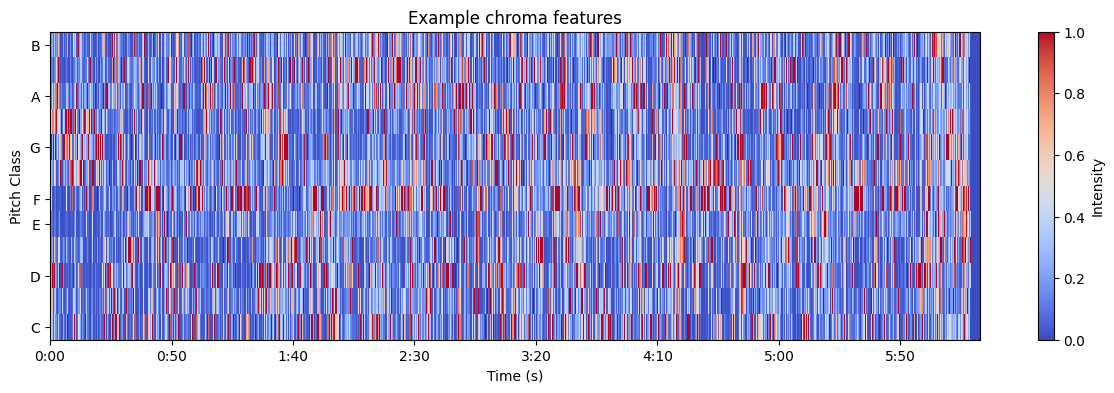

In [26]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(example_chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar(label="Intensity")
plt.title("Example chroma features")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()

## Query chroma features

In [41]:
# Create directory to save chroma features
os.makedirs(query_chroma_path, exist_ok=True)

for file_name in os.listdir(query_path):
    if file_name.endswith(".wav"):
        file_path = os.path.join(query_path, file_name)

        # Load audio
        y, sr = librosa.load(file_path)

        # Crop to the first 10 seconds
        y = y[:sr * 10]

        # Compute chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=2048, hop_length=512)
        y = None
        
        # Save chroma features
        base_name = os.path.splitext(file_name)[0]
        save_path = f"{base_name}.npy"
        np.save(os.path.join(query_chroma_path, save_path), chroma, allow_pickle=False)

In [42]:
example_chroma = np.load(os.path.join(query_chroma_path, 'q9.npy'))

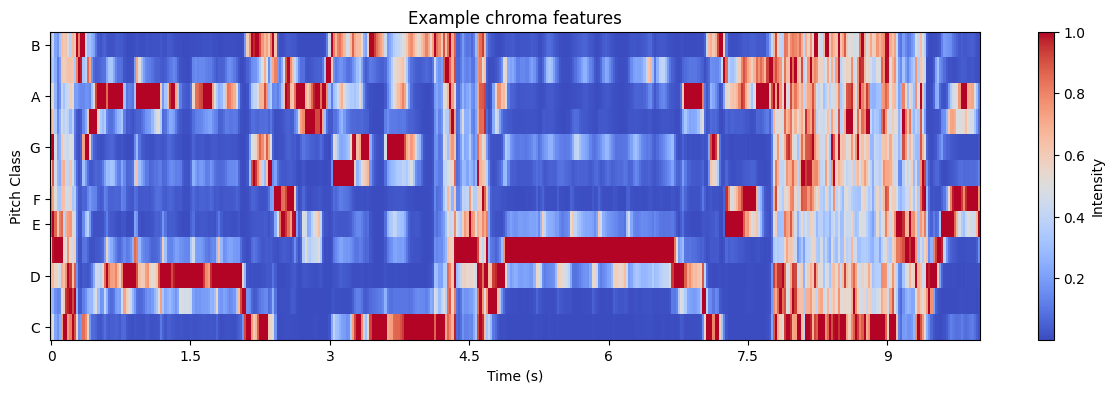

In [43]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(example_chroma, x_axis="time", y_axis="chroma", cmap="coolwarm")
plt.colorbar(label="Intensity")
plt.title("Example chroma features")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Class")
plt.show()